<a href="https://colab.research.google.com/github/Subhraj07/Machine_Learning_Models/blob/master/MLpractice/CEREBRINOCS/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!sudo apt install tesseract-ocr

In [0]:
!pip install pytesseract

In [0]:
# !unzip '/content/drive/My Drive/Vehicle_Licenseplate_Detection/Datasets/train20X20.zip'
# import shutil
# shutil.move("/content/train20X20", "/content/drive/My Drive/Vehicle_Licenseplate_Detection/Datasets/") 

In [12]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from skimage.io import imread
from skimage.filters import threshold_otsu

letters = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
        ]

def read_training_data(training_directory):
    image_data = []
    target_data = []
    for each_letter in letters:
        for each in range(10):
            image_path = os.path.join(training_directory, each_letter, each_letter + '_' + str(each) + '.jpg')
            # read each image of each character
            img_details = imread(image_path, as_gray=True)
            # converts each character image to binary image
            binary_image = img_details < threshold_otsu(img_details)
            # the 2D array of each image is flattened because the machine learning
            # classifier requires that each sample is a 1D array
            # therefore the 20*20 image becomes 1*400
            # in machine learning terms that's 400 features with each pixel
            # representing a feature
            flat_bin_image = binary_image.reshape(-1)
            image_data.append(flat_bin_image)
            target_data.append(each_letter)

    return (np.array(image_data), np.array(target_data))
  
training_dataset_dir = '/content/drive/My Drive/Vehicle_Licenseplate_Detection/Datasets/train20X20'
image_data, target_data = read_training_data(training_dataset_dir)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# from keras.models import Sequential  # To initialise the nn as a sequence of layers
# from keras.layers import Convolution2D  # To make the convolution layer for 2D images
# from keras.layers import MaxPooling2D  #
# from keras.layers import Flatten
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras.callbacks import CSVLogger
# from keras.optimizers import RMSprop

# # Initialising the CNN
# classifier = Sequential()

# # Step 1 - Convolution
# classifier.add(Convolution2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))
# # Step 2 - Pooling
# classifier.add(MaxPooling2D(pool_size=(2, 2)))

# # Step 1 - Convolution
# classifier.add(Convolution2D(32, (3, 3), activation='relu'))
# # Step 2 - Pooling
# classifier.add(MaxPooling2D(pool_size=(2, 2)))
# # Step 3 - Flattening
# classifier.add(Flatten())

# classifier.add(Dense(128, activation='relu'))
# classifier.add(Dropout((0.07)))
# classifier.add(Dense(36, activation='softmax'))

# csv = CSVLogger("/content/drive/My Drive/Vehicle_Licenseplate_Detection/Datasets/VLPR/Metrics_Evaluation/epochs2.log")

# # Compiling the CNN
# classifier.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.005), loss='categorical_crossentropy',
#                    metrics=['accuracy'])

# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1. / 255)

# test_datagen = ImageDataGenerator(rescale=1. / 255)

# train_set = train_datagen.flow_from_directory('Train', target_size=(64, 64), batch_size=32, class_mode='categorical')

# test_set = test_datagen.flow_from_directory('Test', target_size=(64, 64), batch_size=32, class_mode='categorical')

# classifier.fit_generator(train_set, steps_per_epoch=47605, epochs=5, validation_data=test_set, validation_steps=1292,
#                          callbacks=[csv])

# classifier.save('/content/drive/My Drive/Vehicle_Licenseplate_Detection/Datasets/VLPR/Metrics_Evaluation/char-reg.h5')

In [0]:
import cv2
import numpy as np
import math
# module level variables ##########################################################################
GAUSSIAN_SMOOTH_FILTER_SIZE = (5, 5)
ADAPTIVE_THRESH_BLOCK_SIZE = 19
ADAPTIVE_THRESH_WEIGHT = 9

###################################################################################################
def preprocess(imgOriginal):
    imgGrayscale = extractValue(imgOriginal) # We get the gray scale of the image.
    #imgGrayscale = cv2.equalizeHist(imgGrayscale)
    imgMaxContrastGrayscale = maximizeContrast(imgGrayscale) # contrast is the difference between light and dark in an image. High contrast images will have bright highlights and dark shadows,bold colours, and show texture in the subject. Low contrast images will have a narrow range of tones and might therefore feel flat or dull
    height,width = imgGrayscale.shape
    imgBlurred = np.zeros((height, width, 1), np.uint8)

    imgBlurred = cv2.GaussianBlur(imgMaxContrastGrayscale, GAUSSIAN_SMOOTH_FILTER_SIZE, 0) # 2nd parameter is (height,width) of Gaussian kernel,3rd parameter is sigmaX,4th parameter is sigmaY(as not specified it is made same as sigmaX).
    
    imgThresh = cv2.adaptiveThreshold(imgBlurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)
    
    return imgGrayscale, imgThresh

###################################################################################################
def extractValue(imgOriginal):
    height, width, numChannels = imgOriginal.shape

    imgHSV = np.zeros((height, width, 3), np.uint8)

    imgHSV = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2HSV)

    imgHue, imgSaturation, imgValue = cv2.split(imgHSV)

    return imgValue

###################################################################################################
def maximizeContrast(imgGrayscale):

    height, width = imgGrayscale.shape

    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)

    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)) # Same as np.ones((3,3)

    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement) # It is difference of  input image and Opening of the image
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement) # it is difference of closing of the input image and input image.

    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    return imgGrayscalePlusTopHatMinusBlackHat


In [0]:
import cv2
import numpy as np
import math

###################################################################################################
class PossibleChar:

    # constructor #################################################################################
    def __init__(self, _contour):
        self.contour = _contour

        self.boundingRect = cv2.boundingRect(self.contour) # It gives the (x,y,w,h) of a straight rectangle that bounds the contour. It is not sensetive to the rotation of the obejct ,so its area will not be minimum.

        [intX, intY, intWidth, intHeight] = self.boundingRect

        self.intBoundingRectX = intX
        self.intBoundingRectY = intY
        self.intBoundingRectWidth = intWidth
        self.intBoundingRectHeight = intHeight

        self.intBoundingRectArea = self.intBoundingRectWidth * self.intBoundingRectHeight

        self.intCenterX = (self.intBoundingRectX + self.intBoundingRectX + self.intBoundingRectWidth) / 2
        self.intCenterY = (self.intBoundingRectY + self.intBoundingRectY + self.intBoundingRectHeight) / 2

        self.fltDiagonalSize = math.sqrt((self.intBoundingRectWidth ** 2) + (self.intBoundingRectHeight ** 2))

        self.fltAspectRatio = float(self.intBoundingRectWidth) / float(self.intBoundingRectHeight)

In [0]:
import cv2
import numpy as np

###################################################################################################
class PossiblePlate:

    # constructor #################################################################################
    def __init__(self):
        self.imgPlate = None
        self.imgGrayscale = None
        self.imgThresh = None

        self.rrLocationOfPlateInScene = None

        self.strChars = ""

In [0]:
# DetectChars.py

import cv2
import numpy as np
import math
import random
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.optimizers import RMSprop

# module level variables ##########################################################################
        # constants for checkIfPossibleChar, this checks one possible char only (does not compare to another char)
MIN_PIXEL_WIDTH = 2
MIN_PIXEL_HEIGHT = 8

MIN_ASPECT_RATIO = 0.25
MAX_ASPECT_RATIO = 1.0

MIN_PIXEL_AREA = 80

        # constants for comparing two chars
MIN_DIAG_SIZE_MULTIPLE_AWAY = 0.3
MAX_DIAG_SIZE_MULTIPLE_AWAY = 5.0

MAX_CHANGE_IN_AREA = 0.5

MAX_CHANGE_IN_WIDTH = 0.8
MAX_CHANGE_IN_HEIGHT = 0.2

MAX_ANGLE_BETWEEN_CHARS = 12.0

        # other constants
MIN_NUMBER_OF_MATCHING_CHARS = 3

RESIZED_CHAR_IMAGE_WIDTH = 64
RESIZED_CHAR_IMAGE_HEIGHT = 64

MIN_CONTOUR_AREA = 100
model = load_model('/content/drive/My Drive/Vehicle_Licenseplate_Detection/Datasets/char-reg.h5')
###################################################################################################
def loadCNNClassifier():
    model.compile(optimizer = RMSprop(lr=0.001,rho=0.9,epsilon=1e-08,decay=0.005), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return True###################################################################################################
def detectCharsInPlates(listOfPossiblePlates):
    intPlateCounter = 0
    imgContours = None
    contours = []

    if len(listOfPossiblePlates) == 0:          # if list of possible plates is empty
        return listOfPossiblePlates             # return
    # end if

            # at this point we can be sure the list of possible plates has at least one plate
    listOfPossiblePlates_refined = []
    for possiblePlate in listOfPossiblePlates:          # for each possible plate, this is a big for loop that takes up most of the function
        #possiblePlate.imgPlate = cv2.fastNlMeansDenoisingColored(possiblePlate.imgPlate,None,15,15,7,21)
        #possiblePlate.imgPlate = cv2.equalizeHist(possiblePlate.imgPlate)
        possiblePlate.imgGrayscale, possiblePlate.imgThresh = preprocess(possiblePlate.imgPlate)     # preprocess to get grayscale and threshold images

            
        possiblePlate.imgThresh = cv2.resize(possiblePlate.imgThresh, (0, 0), fx = 1.6, fy = 1.6,interpolation=cv2.INTER_LINEAR)

                # threshold again to eliminate any gray areas
        thresholdValue, possiblePlate.imgThresh = cv2.threshold(possiblePlate.imgThresh, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        # This clears the image more removing all the unknown noise from it.
        if showSteps == True: # show steps ###################################################
            Image.fromarray(possiblePlate.imgThresh).show()
#             input('Press Enter to Continue....')
        # end if # show steps #####################################################################

                # find all possible chars in the plate,
                # this function first finds all contours, then only includes contours that could be chars (without comparison to other chars yet)
        listOfPossibleCharsInPlate = findPossibleCharsInPlate(possiblePlate.imgGrayscale, possiblePlate.imgThresh)

        if showSteps == True: # show steps ###################################################
            height, width, numChannels = possiblePlate.imgPlate.shape
            imgContours = np.zeros((height, width, 3), np.uint8)
            del contours[:]                                         # clear the contours list

            for possibleChar in listOfPossibleCharsInPlate:
                contours.append(possibleChar.contour)
            # end for

            cv2.drawContours(imgContours, contours, -1, SCALAR_WHITE)
            #print('These are the possible characters in the plate :')
            imgContours = Image.fromarray(imgContours,'RGB')
            imgContours.show()
#             input('Press Enter to Continue....')
        # end if # show steps #####################################################################

                # given a list of all possible chars, find groups of matching chars within the plate
        listOfListsOfMatchingCharsInPlate = findListOfListsOfMatchingChars(listOfPossibleCharsInPlate)
        if (len(listOfListsOfMatchingCharsInPlate) == 0):            # if no groups of matching chars were found in the plate
            #print('\nNo matching characters found:')
            if showSteps == True: # show steps ###############################################
#                 print("chars found in plate number " + str(intPlateCounter) + " = (none), click on any image and press a key to continue . . .")
                intPlateCounter = intPlateCounter + 1

                
            # end if # show steps #################################################################

            possiblePlate.strChars = ""
            continue                        # go back to top of for loop
        # end if

        if showSteps == True: # show steps ###################################################
            imgContours = np.zeros((height, width, 3), np.uint8)
            del contours[:]

            for listOfMatchingChars in listOfListsOfMatchingCharsInPlate:
                intRandomBlue = random.randint(0, 255)
                intRandomGreen = random.randint(0, 255)
                intRandomRed = random.randint(0, 255)

                for matchingChar in listOfMatchingChars:
                    contours.append(matchingChar.contour)
                # end for
                cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
            # end for
            imgContours = Image.fromarray(imgContours,'RGB')
            imgContours.show()
#             input('Press Enter to Continue....')
        # end if # show steps #####################################################################

        for i in range(0, len(listOfListsOfMatchingCharsInPlate)):                              # within each list of matching chars
            listOfListsOfMatchingCharsInPlate[i].sort(key = lambda matchingChar: matchingChar.intCenterX)        # sort chars from left to right
            listOfListsOfMatchingCharsInPlate[i] = removeInnerOverlappingChars(listOfListsOfMatchingCharsInPlate[i])              # and remove inner overlapping chars
        # end for

        if showSteps == True: # show steps ###################################################
            imgContours = np.zeros((height, width, 3), np.uint8)

            for listOfMatchingChars in listOfListsOfMatchingCharsInPlate:
                intRandomBlue = random.randint(0, 255)
                intRandomGreen = random.randint(0, 255)
                intRandomRed = random.randint(0, 255)

                del contours[:]

                for matchingChar in listOfMatchingChars:
                    contours.append(matchingChar.contour)
                # end for

                cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
            # end for
            imgContours = Image.fromarray(imgContours,'RGB')
            imgContours.show()
#             input('Press Enter to Continue....')
        # end if # show steps #####################################################################

                # within each possible plate, suppose the longest list of potential matching chars is the actual list of chars
        intLenOfLongestListOfChars = 0
        intIndexOfLongestListOfChars = 0

                # loop through all the vectors of matching chars, get the index of the one with the most chars
        for i in range(0, len(listOfListsOfMatchingCharsInPlate)):
            if len(listOfListsOfMatchingCharsInPlate[i]) > intLenOfLongestListOfChars:
                intLenOfLongestListOfChars = len(listOfListsOfMatchingCharsInPlate[i])
                intIndexOfLongestListOfChars = i
            # end if
        # end for

                # suppose that the longest list of matching chars within the plate is the actual list of chars
        longestListOfMatchingCharsInPlate = listOfListsOfMatchingCharsInPlate[intIndexOfLongestListOfChars]

        if showSteps == True: # show steps ###################################################
            imgContours = np.zeros((height, width, 3), np.uint8)
            del contours[:]

            for matchingChar in longestListOfMatchingCharsInPlate:
                contours.append(matchingChar.contour)
            # end for

            cv2.drawContours(imgContours, contours, -1, SCALAR_WHITE)
            imgContours = Image.fromarray(imgContours,'RGB')
            imgContours.show()
            
            #cv2.imshow("The_Longest_list_of_matching_chars", imgContours)
            #cv2.waitKey(0)
        # end if # show steps #####################################################################

        possiblePlate.strChars = recognizeCharsInPlate(possiblePlate.imgThresh, longestListOfMatchingCharsInPlate)
        #print('this character is recognized :',possiblePlate.strChars)
        listOfPossiblePlates_refined.append(possiblePlate)

        if showSteps == True: # show steps ###################################################
#             print("chars found in plate number " + str(intPlateCounter) + " = " + possiblePlate.strChars + ", . . .")
            intPlateCounter = intPlateCounter + 1
        # end if # show steps #####################################################################

    # end of big for loop that takes up most of the function

    if showSteps == True:
        print("\nchar detection complete, . . .")
    # end if
    return listOfPossiblePlates_refined # we return the list of plates with the probable plate number of each plate.

###################################################################################################
def findPossibleCharsInPlate(imgGrayscale, imgThresh):
    listOfPossibleChars = []                        # this will be the return value
    contours = []
    imgThreshCopy = imgThresh.copy()

            # find all contours in plate
    imgContours, contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:                        # for each contour
        possibleChar = PossibleChar(contour)

        if checkIfPossibleChar(possibleChar):              # if contour is a possible char, note this does not compare to other chars (yet) . . .
            listOfPossibleChars.append(possibleChar)       # add to list of possible chars
        # end if
    # end if

    return listOfPossibleChars
# end function

###################################################################################################
def checkIfPossibleChar(possibleChar):
            # this function is a 'first pass' that does a rough check on a contour to see if it could be a char,
            # note that we are not (yet) comparing the char to other chars to look for a group
    if (possibleChar.intBoundingRectArea > MIN_PIXEL_AREA and
        possibleChar.intBoundingRectWidth > MIN_PIXEL_WIDTH and possibleChar.intBoundingRectHeight > MIN_PIXEL_HEIGHT and
        MIN_ASPECT_RATIO < possibleChar.fltAspectRatio and possibleChar.fltAspectRatio < MAX_ASPECT_RATIO):
        return True
    else:
        return False


###################################################################################################
def findListOfListsOfMatchingChars(listOfPossibleChars):
            # with this function, we start off with all the possible chars in one big list
            # the purpose of this function is to re-arrange the one big list of chars into a list of lists of matching chars,
            # note that chars that are not found to be in a group of matches do not need to be considered further
    listOfListsOfMatchingChars = []                  # this will be the return value
    #print("Now we check which contours are similar")

    for possibleChar in listOfPossibleChars:                        # for each possible char in the one big list of chars

        #print('We are checking for :')
        #imgContours = np.zeros((height, width, 3), np.uint8)
        #cv2.drawContours(imgContours, possibleChar.contour, -1, SCALAR_WHITE)
        #cv2.imshow("2b", imgContours)
        #cv2.waitKey(0)

        listOfMatchingChars = findListOfMatchingChars(possibleChar, listOfPossibleChars)        # find all chars in the big list that match the current char
        listOfMatchingChars.append(possibleChar)                # also add the current char to current possible list of matching chars
        if len(listOfMatchingChars) < MIN_NUMBER_OF_MATCHING_CHARS:     # if current possible list of matching chars is not long enough to constitute a possible plate
            #print('Now a plate is complete')
            continue
        listOfListsOfMatchingChars.append(listOfMatchingChars)
        listOfPossibleCharsWithCurrentMatchesRemoved = list(set(listOfPossibleChars) - set(listOfMatchingChars))
        recursiveListOfListsOfMatchingChars = findListOfListsOfMatchingChars(listOfPossibleCharsWithCurrentMatchesRemoved)      # recursive call
        for recursiveListOfMatchingChars in recursiveListOfListsOfMatchingChars:        # for each list of matching chars found by recursive call
            listOfListsOfMatchingChars.append(recursiveListOfMatchingChars)
        break;



    return listOfListsOfMatchingChars
# end function

###################################################################################################
def findListOfMatchingChars(possibleChar, listOfChars):
            # the purpose of this function is, given a possible char and a big list of possible chars,
            # find all chars in the big list that are a match for the single possible char, and return those matching chars as a list
    listOfMatchingChars = []                # this will be the return value

    for possibleMatchingChar in listOfChars:                # for each char in big list
        if possibleMatchingChar == possibleChar:    # if the char we attempting to find matches for is the exact same char
                                                    # as the char in the big list we are currently checking
                                                    # then we should not include it in the list of matches b/c that would
                                                    # end up double including the current char
            continue                                # so do not add to list of matches and jump back to top of for loop
        # end if
                    # compute stuff to see if chars are a match
        fltDistanceBetweenChars = distanceBetweenChars(possibleChar, possibleMatchingChar)

        fltAngleBetweenChars = angleBetweenChars(possibleChar, possibleMatchingChar)

        fltChangeInArea = float(abs(possibleMatchingChar.intBoundingRectArea - possibleChar.intBoundingRectArea)) / float(possibleChar.intBoundingRectArea)

        fltChangeInWidth = float(abs(possibleMatchingChar.intBoundingRectWidth - possibleChar.intBoundingRectWidth)) / float(possibleChar.intBoundingRectWidth)
        fltChangeInHeight = float(abs(possibleMatchingChar.intBoundingRectHeight - possibleChar.intBoundingRectHeight)) / float(possibleChar.intBoundingRectHeight)

                # check if chars match
        if (fltDistanceBetweenChars < (possibleChar.fltDiagonalSize * MAX_DIAG_SIZE_MULTIPLE_AWAY) and
            fltAngleBetweenChars < MAX_ANGLE_BETWEEN_CHARS and
            fltChangeInArea < MAX_CHANGE_IN_AREA and
            fltChangeInWidth < MAX_CHANGE_IN_WIDTH and
            fltChangeInHeight < MAX_CHANGE_IN_HEIGHT):

            listOfMatchingChars.append(possibleMatchingChar)        # if the chars are a match, add the current char to list of matching chars
            #print("\t This contour is same:")
            #cv2.drawContours(imgContours, possibleMatchingChar.contour, -1, SCALAR_WHITE)
            #cv2.imshow("2b", imgContours)
            #cv2.waitKey(0)
        # end if
    # end for

    return listOfMatchingChars                  # return result
# end function

# use Pythagorean theorem to calculate distance between two chars
def distanceBetweenChars(firstChar, secondChar):
    intX = abs(firstChar.intCenterX - secondChar.intCenterX)
    intY = abs(firstChar.intCenterY - secondChar.intCenterY)

    return math.sqrt((intX ** 2) + (intY ** 2))

# use basic trigonometry (SOH CAH TOA) to calculate angle between chars
def angleBetweenChars(firstChar, secondChar):
    fltAdj = float(abs(firstChar.intCenterX - secondChar.intCenterX))
    fltOpp = float(abs(firstChar.intCenterY - secondChar.intCenterY))

    if fltAdj != 0.0:                           # check to make sure we do not divide by zero if the center X positions are equal, float division by zero will cause a crash in Python
        fltAngleInRad = math.atan(fltOpp / fltAdj)      # if adjacent is not zero, calculate angle
    else:
        fltAngleInRad = 1.5708                          # if adjacent is zero, use this as the angle, this is to be consistent with the C++ version of this program
    # end if

    fltAngleInDeg = fltAngleInRad * (180.0 / math.pi)       # calculate angle in degrees

    return fltAngleInDeg
# end function
###################################################################################################

# if we have two chars overlapping or to close to each other to possibly be separate chars, remove the inner (smaller) char,
# this is to prevent including the same char twice if two contours are found for the same char,
# for example for the letter 'O' both the inner ring and the outer ring may be found as contours, but we should only include the char once
def removeInnerOverlappingChars(listOfMatchingChars):
    listOfMatchingCharsWithInnerCharRemoved = list(listOfMatchingChars)                # this will be the return value

    for currentChar in listOfMatchingChars:
        for otherChar in listOfMatchingChars:
            if currentChar != otherChar:        # if current char and other char are not the same char . . .
                                                                            # if current char and other char have center points at almost the same location . . .
                if distanceBetweenChars(currentChar, otherChar) < (currentChar.fltDiagonalSize * MIN_DIAG_SIZE_MULTIPLE_AWAY):
                                # if we get in here we have found overlapping chars
                                # next we identify which char is smaller, then if that char was not already removed on a previous pass, remove it
                    if currentChar.intBoundingRectArea < otherChar.intBoundingRectArea:         # if current char is smaller than other char
                        if currentChar in listOfMatchingCharsWithInnerCharRemoved:              # if current char was not already removed on a previous pass . . .
                            listOfMatchingCharsWithInnerCharRemoved.remove(currentChar)         # then remove current char
                        # end if
                    else:                                                                       # else if other char is smaller than current char
                        if otherChar in listOfMatchingCharsWithInnerCharRemoved:                # if other char was not already removed on a previous pass . . .
                            listOfMatchingCharsWithInnerCharRemoved.remove(otherChar)           # then remove other char
                        # end if
                    # end if
                # end if
            # end if
        # end for
    # end for

    return listOfMatchingCharsWithInnerCharRemoved
# end function

###################################################################################################
# this is where we apply the actual char recognition
def recognizeCharsInPlate(imgThresh, listOfMatchingChars):
    strChars = ""               # this will be the return value, the chars in the lic plate

    height, width = imgThresh.shape
    imgThreshColor = np.zeros((height, width, 3), np.uint8)
    #imgThresh = cv2.cvtColor(imgThresh, cv2.COLOR_BGR2HSV)
    #imgHue, imgSaturation, imgThresh = cv2.split(imgHSV)
    #cv2.threshold(possiblePlate.imgThresh, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #imgThreshColor = imgThresh.copy()
    #imgThreshColor = cv2.resize(imgThreshColor, (0, 0), fx = 1.6, fy = 1.6)
    thresholdValue, imgThresh = cv2.threshold(imgThresh, 0.0, 255.0, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    #imgThresh = cv2.fastNlMeansDenoising(imgThresh,None,10,10,7,21)
    cv2.cvtColor(imgThresh, cv2.COLOR_GRAY2BGR, imgThreshColor)
    #cv2.imshow('The Image',imgThreshColor)
    #cv2.waitKey(0)
    imgThreshColor2 = imgThreshColor.copy()
    #cv2.imshow('The Plate',imgThreshColor2)
    #cv2.waitKey(0)
    listOfMatchingChars.sort(key = lambda matchingChar: matchingChar.intCenterX)        # sort chars from left to right

    for currentChar in listOfMatchingChars:                                         # for each char in plate
        pt1 = (currentChar.intBoundingRectX, currentChar.intBoundingRectY)
        pt2 = ((currentChar.intBoundingRectX + currentChar.intBoundingRectWidth), (currentChar.intBoundingRectY + currentChar.intBoundingRectHeight))

        cv2.rectangle(imgThreshColor2, pt1, pt2, (255,0,0), 2)           # draw green box around the char
                # crop char out of threshold image
        imgROI = imgThreshColor[currentChar.intBoundingRectY : currentChar.intBoundingRectY + currentChar.intBoundingRectHeight,currentChar.intBoundingRectX : currentChar.intBoundingRectX + currentChar.intBoundingRectWidth]
        imgROI = cv2.copyMakeBorder(imgROI,8,8,8,8,cv2.BORDER_CONSTANT,value = [255,255,255])

                # crop char out of threshold image    
        #Image.fromarray(imgROI,'RGB').show()
        #input('Press Enter to Continue....')
        imgROIResized = cv2.resize(imgROI, (RESIZED_CHAR_IMAGE_WIDTH, RESIZED_CHAR_IMAGE_HEIGHT),interpolation=cv2.INTER_LINEAR)           # resize image, this is necessary for char recognition
        #print('The shape is :',imgROIResized.shape)
        #Image.fromarray(imgROI,'RGB').show()
        #input('Press Enter to Continue....')
        """
        response = str(input('Want to save the image: '))
        if response == 'Y':
            name = str(input('Enter the name: '))
            cv2.imwrite(name, imgROIResized)
        """
        img=np.reshape(imgROIResized,[1,64,64,3])

        classes=model.predict_classes(img)
        if classes[0]<10:
            strCurrentChar = chr(classes[0]+48) # get character from results
        else:
            strCurrentChar = chr(classes[0]+55)    # get character from results
        if showSteps == True:
          pass
#         	print(strCurrentChar)
  
        strChars = strChars + strCurrentChar                        # append current char to full string


    # end for

    if showSteps == True: # show steps #######################################################
        imgThreshColor2 = Image.fromarray(imgThreshColor2,'RGB')
        imgThreshColor2.show()
#         input('Press Enter to Continue....')
    # end if # show steps #########################################################################

    return strChars
# end function

In [0]:
# DetectPlates.py

import cv2
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from PIL import Image

# module level variables ##########################################################################
PLATE_WIDTH_PADDING_FACTOR = 1.3
PLATE_HEIGHT_PADDING_FACTOR = 1.5

###################################################################################################
def detectPlatesInScene(imgOriginalScene):
    listOfPossiblePlates = []                   # this will be the return value

    height, width, numChannels = imgOriginalScene.shape

    imgGrayscaleScene = np.zeros((height, width, 1), np.uint8)
    imgThreshScene = np.zeros((height, width, 1), np.uint8)
    imgContours = np.zeros((height, width, 3), np.uint8)

    if showSteps == True: # show steps #######################################################
        #cv2.imshow("0", imgOriginalScene)
        Image.fromarray(imgOriginalScene).show()
#         input('Press any key to continue...')
        
    imgGrayscaleScene, imgThreshScene = preprocess(imgOriginalScene)         # preprocess to get grayscale and threshold images

            # find all possible chars in the scene,
            # this function first finds all contours, then only includes contours that could be chars (without comparison to other chars yet)
    listOfPossibleCharsInScene = findPossibleCharsInScene(imgThreshScene) # Here we get a list of all the contours in the image that may be characters.
    

    if showSteps == True: # show steps #######################################################
        #print("step 2 - len(listOfPossibleCharsInScene) = " + str(len(listOfPossibleCharsInScene)))

        imgContours = np.zeros((height, width, 3), np.uint8)

        contours = []

        for possibleChar in listOfPossibleCharsInScene:
            contours.append(possibleChar.contour)

        cv2.drawContours(imgContours, contours, -1, SCALAR_WHITE)
        Image.fromarray(imgOriginalScene).show()
#         input('Press any key to continue...')
        # This is for the boxing of all the contours
        """
        for possibleChar in listOfPossibleCharsInScene:
            cv2.rectangle(imgContours,(possibleChar.intBoundingRectX,possibleChar.intBoundingRectY),(possibleChar.intBoundingRectX+possibleChar.intBoundingRectWidth,possibleChar.intBoundingRectY+possibleChar.intBoundingRectHeight),(0.0, 255.0, 255.0),1)
            cv2.imshow('PossiblePlate',imgContours)
            cv2.waitKey(0)

        """
            # given a list of all possible chars, find groups of matching chars
            # in the next steps each group of matching chars will attempt to be recognized as a plate
    listOfListsOfMatchingCharsInScene = findListOfListsOfMatchingChars(listOfPossibleCharsInScene)
    if showSteps == True: # show steps #######################################################
#         print("step 3 - listOfListsOfMatchingCharsInScene.Count = " + str(len(listOfListsOfMatchingCharsInScene)))    # 13 with MCLRNF1 image

        imgContours = np.zeros((height, width, 3), np.uint8)

        for listOfMatchingChars in listOfListsOfMatchingCharsInScene:
            intRandomBlue = random.randint(0, 255)
            intRandomGreen = random.randint(0, 255)
            intRandomRed = random.randint(0, 255)

            #imgContours2 = np.zeros((height, width, 3), np.uint8)

            contours = []

            for matchingChar in listOfMatchingChars:
                contours.append(matchingChar.contour)
            # end for

            #cv2.drawContours(imgContours, contours, -1, (255, 255, 255))
            cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
        # end for
            
            #imgContours = Image.fromarray(imgContours,'RGB').show()
            
        
    # end if # show steps #########################################################################
    for listOfMatchingChars in listOfListsOfMatchingCharsInScene:                   # for each group of matching chars
        possiblePlate = extractPlate(imgOriginalScene, listOfMatchingChars)         # attempt to extract plate

        if possiblePlate.imgPlate is not None:                          # if plate was found
            listOfPossiblePlates.append(possiblePlate)                  # add to list of possible plates
            

    if showSteps == True:
      pass
#         print("\n" + str(len(listOfPossiblePlates)) + " possible plates found")
  
    if showSteps == True: # show steps #######################################################
#         print("\n")
        
        Image.fromarray(imgContours,'RGB').show()
#         input('Press any key to continue...')
        for i in range(0, len(listOfPossiblePlates)):
            p2fRectPoints = cv2.boxPoints(listOfPossiblePlates[i].rrLocationOfPlateInScene)

            cv2.line(imgContours, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), SCALAR_RED, 2)
            cv2.line(imgContours, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), SCALAR_RED, 2)
            cv2.line(imgContours, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), SCALAR_RED, 2)
            cv2.line(imgContours, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), SCALAR_RED, 2)

            #cv2.imshow("4a", imgContours)
            
#             print("possible plate " + str(i) + ", click on any image and press a key to continue . . .")
            #Image.fromarray(listOfPossiblePlates[i].imgPlate,'RGB').show()
            
        # end for
#         print("\nplate detection complete, press a key to begin char recognition . . .\n")
#         input()
    # end if # show steps #########################################################################
    
    return listOfPossiblePlates

###################################################################################################
def findPossibleCharsInScene(imgThresh):
    listOfPossibleChars = []                # this will be the return value

    intCountOfPossibleChars = 0

    imgThreshCopy = imgThresh.copy()
    #print('Now we start to find the contours in the thresholded image that may be characters:')

    imgContours, contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)   # find all contours

    height, width = imgThresh.shape
    imgContours = np.zeros((height, width, 3), np.uint8)

    for i in range(0, len(contours)):                       # for each contour

        if showSteps == True: # show steps ###################################################
            cv2.drawContours(imgContours, contours, i, SCALAR_YELLOW)
            #Image.fromarray(imgContours,'RGB').show()
            
        possibleChar = PossibleChar(contours[i]) # Here we calculate the x,y,w,h,flatdiagonalsize,aspedctratio,area and (x,y) of the center of the rectangle that is bounding the contour.

        if checkIfPossibleChar(possibleChar):                   # if contour is a possible char, note this does not compare to other chars (yet) . . .
            intCountOfPossibleChars = intCountOfPossibleChars + 1           # increment count of possible chars
            listOfPossibleChars.append(possibleChar)                        # and add to list of possible chars
            #cv2.drawContours(imgContours, contours, i, SCALAR_WHITE)
            #print('This contour may be a character :')
        #else:
            #print('This contour is not a character :')
        # end if
    # end for

    if showSteps == True: # show steps #######################################################
#         print("\nstep 2 - Total number of contours found in the image are = " + str(len(contours)))
#         print("step 2 - number of contours those may be characters = " + str(intCountOfPossibleChars))
        #print("These are the contours those may be characters :")
        Image.fromarray(imgContours,'RGB').show()
    # end if # show steps #########################################################################

    return listOfPossibleChars

###################################################################################################
def extractPlate(imgOriginal, listOfMatchingChars):
    possiblePlate = PossiblePlate()           # this will be the return value

    listOfMatchingChars.sort(key = lambda matchingChar: matchingChar.intCenterX)        # sort chars from left to right based on x position

            # calculate the center point of the plate
    fltPlateCenterX = (listOfMatchingChars[0].intCenterX + listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterX) / 2.0
    fltPlateCenterY = (listOfMatchingChars[0].intCenterY + listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterY) / 2.0
    # This is the probable centeral point of this plate.
    ptPlateCenter = fltPlateCenterX, fltPlateCenterY

            # calculate plate width and height
    intPlateWidth = int((listOfMatchingChars[len(listOfMatchingChars) - 1].intBoundingRectX + listOfMatchingChars[len(listOfMatchingChars) - 1].intBoundingRectWidth - listOfMatchingChars[0].intBoundingRectX) * PLATE_WIDTH_PADDING_FACTOR)
    # Here we calculate the probable width of this plate.
    intTotalOfCharHeights = 0

    for matchingChar in listOfMatchingChars:
        intTotalOfCharHeights = intTotalOfCharHeights + matchingChar.intBoundingRectHeight

    fltAverageCharHeight = intTotalOfCharHeights / len(listOfMatchingChars) # Here we calculate the probale height of this particular plate.

    intPlateHeight = int(fltAverageCharHeight * PLATE_HEIGHT_PADDING_FACTOR) # We include the padding factor.

            # calculate correction angle of plate region
    fltOpposite = listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterY - listOfMatchingChars[0].intCenterY
    fltHypotenuse = distanceBetweenChars(listOfMatchingChars[0], listOfMatchingChars[len(listOfMatchingChars) - 1])
    fltCorrectionAngleInRad = math.asin(fltOpposite / fltHypotenuse)
    fltCorrectionAngleInDeg = fltCorrectionAngleInRad * (180.0 / math.pi)

            # pack plate region center point, width and height, and correction angle into rotated rect member variable of plate
    possiblePlate.rrLocationOfPlateInScene = ( tuple(ptPlateCenter), (intPlateWidth, intPlateHeight), fltCorrectionAngleInDeg )

            # final steps are to perform the actual rotation

            # get the rotation matrix for our calculated correction angle
    rotationMatrix = cv2.getRotationMatrix2D(tuple(ptPlateCenter), fltCorrectionAngleInDeg, 1.0) # The first poin tis the point of rotaion or center,theta and scaling factor


    height, width, numChannels = imgOriginal.shape      # unpack original image width and height

    imgRotated = cv2.warpAffine(imgOriginal, rotationMatrix, (width, height))       # rotate the entire image

    imgCropped = cv2.getRectSubPix(imgRotated, (intPlateWidth, intPlateHeight), tuple(ptPlateCenter)) # We extract the probable plate from the Original image

    possiblePlate.imgPlate = imgCropped         # copy the cropped plate image into the applicable member variable of the possible plate

    return possiblePlate


In [0]:
import cv2
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

SCALAR_BLACK = (0.0, 0.0, 0.0)
SCALAR_WHITE = (255.0, 255.0, 255.0)
SCALAR_YELLOW = (0.0, 255.0, 255.0)
SCALAR_GREEN = (0.0, 255.0, 0.0)
SCALAR_RED = (0.0, 0.0, 255.0)

showSteps = True

def main(image):

    CnnClassifier = loadCNNClassifier()         # attempt KNN training
    #response  = str(input('Do you want to see the Intermediate images: '))
    """
    if response == 'Y' or response == 'y':
        showSteps = True
    else:
        showSteps = False

    """

    if CnnClassifier == False:                               # if KNN training was not successful
        print("\nerror: CNN traning was not successful\n")               # show error message
        return                                                          # and exit program

    imgOriginalScene  = cv2.imread(image)               # open image
    #plt.imshow(imgOriginalScene)
    h, w = imgOriginalScene.shape[:2]
    # As the image may be blurr so we sharpen the image.
    #kernel_shapening4 = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    #imgOriginalScene = cv2.filter2D(imgOriginalScene,-1,kernel_shapening4)
    
    #imgOriginalScene = cv2.resize(imgOriginalScene,(1000,600),interpolation = cv2.INTER_LINEAR)
    
    imgOriginalScene = cv2.resize(imgOriginalScene, (0, 0), fx = 1.4, fy = 1.4,interpolation=cv2.INTER_CUBIC)
    
    #imgOriginalScene = cv2.fastNlMeansDenoisingColored(imgOriginalScene,None,10,10,7,21)
    
    #imgOriginal = imgOriginalScene.copy()
    
    if imgOriginalScene is None:                            # if image was not read successfully
        print("\nerror: image not read from file \n\n")      # print error message to std out
        os.system("pause")                                  # pause so user can see error message
        return                                              # and exit program

    listOfPossiblePlates = detectPlatesInScene(imgOriginalScene)           # detect plates. We get a list of
                                                                                        # combinations of contours that may be a plate.


    listOfPossiblePlates = detectCharsInPlates(listOfPossiblePlates)        # detect chars in plates

    if showSteps == True:
        Image.fromarray(imgOriginalScene,'RGB').show() # show scene image
        

    if len(listOfPossiblePlates) == 0:                          # if no plates were found
        print("\nno license plates were detected\n")             # inform user no plates were found
        response = ' '
        return response,imgOriginalScene
    else:                                                       # else
                # if we get in here list of possible plates has at leat one plate

                # sort the list of possible plates in DESCENDING order (most number of chars to least number of chars)
        listOfPossiblePlates.sort(key = lambda possiblePlate: len(possiblePlate.strChars), reverse = True)

                # suppose the plate with the most recognized chars (the first plate in sorted by string length descending order) is the actual plate
        licPlate = listOfPossiblePlates[0]

        if showSteps == True:
            Image.fromarray(licPlate.imgPlate).show()    # show crop of plate and threshold of plate
            
        if len(licPlate.strChars) == 0:                     # if no chars were found in the plate
            print("\nno characters were detected\n\n")       # show message
            return ' ',imgOriginalScene                                       # and exit program
        # end if

        drawRedRectangleAroundPlate(imgOriginalScene, licPlate)             # draw red rectangle around plate
        """
		# Uncomment this if want to check for individual plate
        print("\nlicense plate read from ", image," :",licPlate.strChars,"\n")
        print("----------------------------------------")
		"""
        if showSteps == True:
            writeLicensePlateCharsOnImage(imgOriginalScene, licPlate)           # write license plate text on the image

            Image.fromarray(imgOriginalScene).show()                # re-show scene image

            cv2.imwrite("imgOriginalScene.png", imgOriginalScene)           # write image out to file
#             input('Press any key to continue...')                    # hold windows open until user presses a key

    return licPlate.strChars,licPlate.imgPlate
###################################################################################################
def drawRedRectangleAroundPlate(imgOriginalScene, licPlate):

    p2fRectPoints = cv2.boxPoints(licPlate.rrLocationOfPlateInScene)            # get 4 vertices of rotated rect. Here, bounding rectangle is drawn with minimum area, so it considers the rotation also

    cv2.line(imgOriginalScene, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), SCALAR_RED, 2)         # draw 4 red lines
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), SCALAR_RED, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), SCALAR_RED, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), SCALAR_RED, 2)
# end function

###################################################################################################
def writeLicensePlateCharsOnImage(imgOriginalScene, licPlate):
    ptCenterOfTextAreaX = 0                             # this will be the center of the area the text will be written to
    ptCenterOfTextAreaY = 0

    ptLowerLeftTextOriginX = 0                          # this will be the bottom left of the area that the text will be written to
    ptLowerLeftTextOriginY = 0

    sceneHeight, sceneWidth, sceneNumChannels = imgOriginalScene.shape
    plateHeight, plateWidth, plateNumChannels = licPlate.imgPlate.shape

    intFontFace = cv2.FONT_HERSHEY_SIMPLEX                      # choose a plain jane font
    fltFontScale = float(plateHeight) / 30.0                    # base font scale on height of plate area
    intFontThickness = int(round(fltFontScale * 1.5))           # base font thickness on font scale

    textSize, baseline = cv2.getTextSize(licPlate.strChars, intFontFace, fltFontScale, intFontThickness)        # call getTextSize

            # unpack roatated rect into center point, width and height, and angle
    ( (intPlateCenterX, intPlateCenterY), (intPlateWidth, intPlateHeight), fltCorrectionAngleInDeg ) = licPlate.rrLocationOfPlateInScene

    intPlateCenterX = int(intPlateCenterX)              # make sure center is an integer
    intPlateCenterY = int(intPlateCenterY)

    ptCenterOfTextAreaX = int(intPlateCenterX)         # the horizontal location of the text area is the same as the plate

    if intPlateCenterY < (sceneHeight * 0.75):                                                  # if the license plate is in the upper 3/4 of the image
        ptCenterOfTextAreaY = int(round(intPlateCenterY)) + int(round(plateHeight * 1.6))      # write the chars in below the plate
    else:                                                                                       # else if the license plate is in the lower 1/4 of the image
        ptCenterOfTextAreaY = int(round(intPlateCenterY)) - int(round(plateHeight * 1.6))      # write the chars in above the plate
    # end if

    textSizeWidth, textSizeHeight = textSize                # unpack text size width and height

    ptLowerLeftTextOriginX = int(ptCenterOfTextAreaX - (textSizeWidth / 2))           # calculate the lower left origin of the text area
    ptLowerLeftTextOriginY = int(ptCenterOfTextAreaY + (textSizeHeight / 2))          # based on the text area center, width, and height

            # write the text on the image
    cv2.putText(imgOriginalScene, licPlate.strChars, (ptLowerLeftTextOriginX, ptLowerLeftTextOriginY), intFontFace, fltFontScale, SCALAR_YELLOW, intFontThickness)

In [65]:
img = '/content/drive/My Drive/Vehicle_Licenseplate_Detection/Datasets/LicPlateImages/img1.jpg'
strChars,imgplate = main(img)
print("Vechile number is ", strChars)


char detection complete, . . .
Vechile number is  DL10CT5806


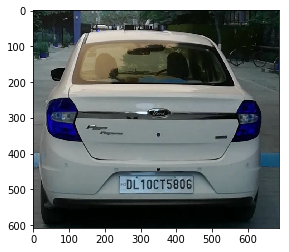

In [59]:
import matplotlib.pyplot as plt
imgOriginalScene = cv2.imread(img)
plt.imshow(imgOriginalScene, cmap="gray")
plt.show()

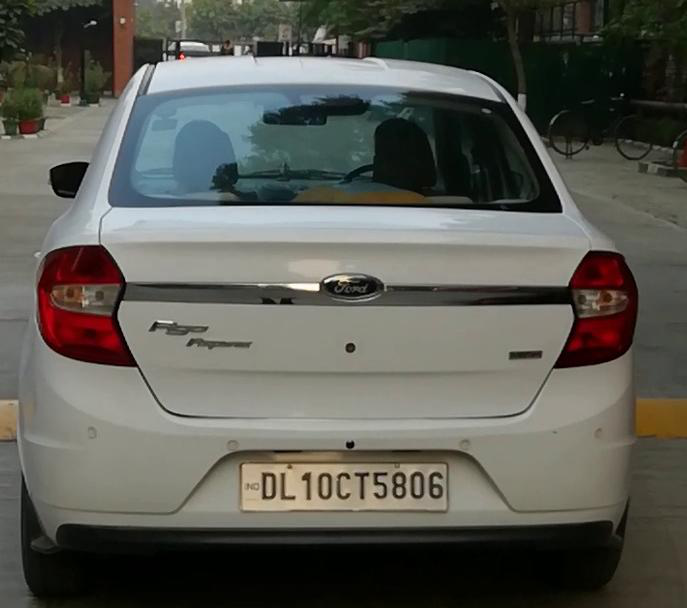

In [60]:
from PIL import Image
from IPython.display import display
pil_im = Image.open(img)
display(pil_im)

# WorkFlow

Main
====
* **DetectChars.loadKNNDataAndTrainKNN()** (Load classification.txt and flattened_image.txt to train a knn classifier for handwritten digit. return the classifier object) [create an object of the OpenCV knn classifier]

* **DetectPlates.detectPlatesInScene()**(Detecting all the possible plates in the image)
  * **Preprocess.preprocess()**(convert the image to grayscale,increase the visibility of plate_area(by blurring and thresholding) ,return the grayscale and thresholded object.)
  * **findPossibleCharsInScene()**(extract all the contours from the image)
    * **PossibleChar.PossibleChar()**(create a class object of each contours that contain physical informations of that particular contour)
    * **DetectChars.checkIfPossibleChar()**(check that if the current contour object can be a character or not, if yes than append the contour to listOfPossibleChars)
    * *return listOfPossibleChars*
  * **re-arrange the one big list of chars into a list of lists of matching chars,where each list can be a license plate in itself.**
    * *return listOfListsOfMatchingChars*
  * **extractPlate**
    * Attempt to extract plates.
    * **PossiblePlate.PossiblePlate()**(Make a class object of the Possible Plate class to store the desires informations of the detected plates)
    * **DetectChars.distanceBetweenChars**
    * *return possiblePlate*
  * *return listOfPossiblePlates*
* **DetectChars.detectCharsInPlates()**
  * detect chars in plates
  * *return listOfPossiblePlates*
* **drawRedRectangleAroundPlate**
  * Draw a box around the prabable position of the name plates
* **writeLicensePlateCharsOnImage**
  * write license plate text on the image
       
 